# Librairies

In [1]:
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pylab as plt
import geopandas as gpd

# Load Data

## Traffic counts

In [2]:
list_df = []
# read file by file 
for file in tqdm(os.listdir('raw/opendata_txt_2023/')):
    sub = pd.read_csv('raw/opendata_txt_2023/' + file, delimiter = ';', usecols = ['iu_ac', 't_1h', 'q'])
    sub.dropna(subset = ['q'], inplace=True)
    list_df.append(sub)
    
df = pd.concat(list_df)

100%|██████████| 68/68 [00:23<00:00,  2.93it/s]


In [3]:
# Memory
list_df = None
# Pre treatment
df.rename(columns={'t_1h':'time'}, inplace= True)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')
df.reset_index(drop=True, inplace=True)
print(df.q.isna().sum())

0


In [4]:
df[(df.iu_ac == 1459) & (df.time == '2023-12-01 01:00:00')]

,iu_ac,time,q
12432620,1459,2023-12-01 01:00:00,16.0
12434054,1459,2023-12-01 01:00:00,16.0


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df

,iu_ac,time,q
0,799,2023-01-01 01:00:00,121.0
1,856,2023-01-01 01:00:00,94.5
2,5026,2023-01-01 01:00:00,394.0
3,6405,2023-01-01 01:00:00,135.0
4,5333,2023-01-01 01:00:00,3913.0
...,...,...,...
14677207,4575,2024-01-01 00:00:00,482.0
14677214,4031,2024-01-01 00:00:00,300.0
14677220,5023,2024-01-01 00:00:00,219.0
14677225,4037,2024-01-01 00:00:00,503.0


## Geographical reference

In [7]:
gdf = gpd.read_file('raw/referentiel-comptages-routiers.geojson')

In [15]:
gdf['raw_direction'] = gdf['libelle_nd_amont'] + ' --> ' +gdf['libelle_nd_aval']
gdf['raw_oneway'] = True

In [16]:
gdf[['iu_ac', 'libelle', 'geometry']]

,iu_ac,libelle,geometry
0,913,Av_Pte_Vincennes,"LINESTRING (2.41385 48.84697, 2.41321 48.84693..."
1,5221,Bd_Gouvion_St_Cyr,"LINESTRING (2.2893 48.88413, 2.28973 48.88441)"
2,852,Bd_Massena,"LINESTRING (2.36943 48.82146, 2.37167 48.82221)"
3,800,Bd_Kellermann,"LINESTRING (2.35466 48.82109, 2.35086 48.82107)"
4,863,Bd_Massena,"LINESTRING (2.38179 48.82581, 2.37949 48.82506)"
...,...,...,...
3734,564,Souterrain_Halles,"LINESTRING (2.34905 48.86386, 2.34779 48.86355..."
3735,6033,Argencon,"LINESTRING (2.31629 48.87517, 2.31575 48.87534)"
3736,269,Av_Champs_Elysees,"LINESTRING (2.3163 48.86716, 2.31477 48.86767)"
3737,214,VGP,"LINESTRING (2.34038 48.8587, 2.34091 48.85858,..."


## Map Matching with OSM

In [17]:
import contextily as cx

(2.1970939636230464, 2.4607003692409752, 48.74910266057992, 48.92261205876504)

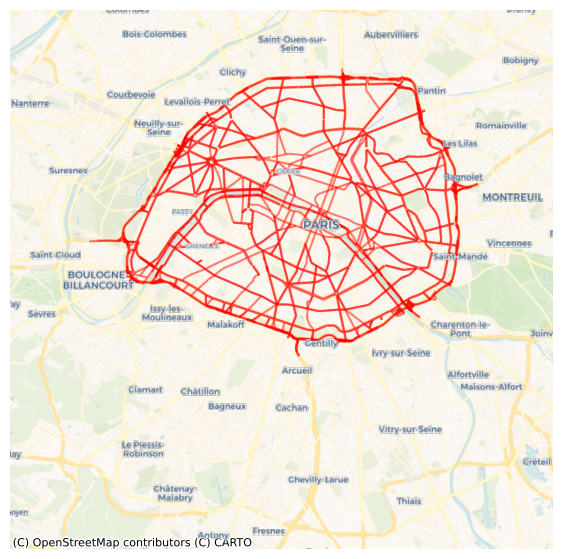

In [18]:
# Plot sensors
ax = gdf.plot(color = 'r', alpha = .5, figsize = (7,7))
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('auto')
plt.axis('off')

In [19]:
# This should be done with gdf prior to join

import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import lines_matching

In [20]:
# Convert in intergrals
gdf.iu_ac = gdf.iu_ac.astype('int')

In [21]:
# Keep only road links where we have measurements
gdf = gdf[gdf.iu_ac.isin(df.iu_ac)]

In [22]:
gdf = lines_matching(gdf, 'Paris, France')

Main graph loaded
Node 2115970900 not reachable from 2030762381
Node 2115970900 not reachable from 2053698581
Node 2115970900 not reachable from 1918497161
Node 2115970900 not reachable from 1937767211
Node 2115970900 not reachable from 2021061922
Node 2115970900 not reachable from 1918497161
Node 2115970900 not reachable from 2053698581
Node 2115970900 not reachable from 1927410430
Node 2115970900 not reachable from 2043868388
Node 893116272 not reachable from 311724860
Node 880124552 not reachable from 311724860
Node 813932141 not reachable from 385295975
Node 813932141 not reachable from 385295975
Node 774693940 not reachable from 385295975
Node 893116272 not reachable from 385295975
Node 880124552 not reachable from 385295975
Node 813932141 not reachable from 385295975
Node 813932141 not reachable from 385295975
Node 813932141 not reachable from 385295975
Node 774693940 not reachable from 385295975
Node 893116272 not reachable from 385295975
Node 880124552 not reachable from 385295

In [23]:
gdf[['libelle', 'osm_name']].drop_duplicates().dropna()[:25]

,libelle,osm_name
0,Av_Pte_Vincennes,Avenue de la Porte de Vincennes
2,Bd_Massena,Boulevard Masséna
3,Bd_Kellermann,Boulevard Kellermann
4,Bd_Massena,Boulevard du Général d'Armée Jean Simon
6,Av_Champs_Elysees,Avenue des Champs-Élysées
7,Av_Champs_Elysees,Rond-point des Champs-Élysées-Marcel-Dassault
10,Souterrain_Dauphine,Place du Maréchal de Lattre de Tassigny
12,Bd_Haussmann,Boulevard Haussmann
13,Bd_Auguste_Blanqui,Boulevard Auguste Blanqui
18,Bd_Magenta,Boulevard de Magenta


In [24]:
# Some sensors appear several times
gdf.drop_duplicates(subset = ['iu_ac'], inplace=True)

In [26]:
gdf.osm_oneway.value_counts()

osm_oneway
True     1137
False     353
Name: count, dtype: int64

In [28]:
gdf.raw_oneway.isna().sum()

0

# Treatment

In [29]:
# Prepare Dataframe
df.set_index(['iu_ac', 'time'], inplace=True)

In [30]:
from temporal_agg import hourly_to_aadt

In [31]:
df = hourly_to_aadt(df, sensor_id_name='iu_ac', time_name='time', counts_name=['q'])

In [32]:
df.columns = ['AADT', 'AAWT']

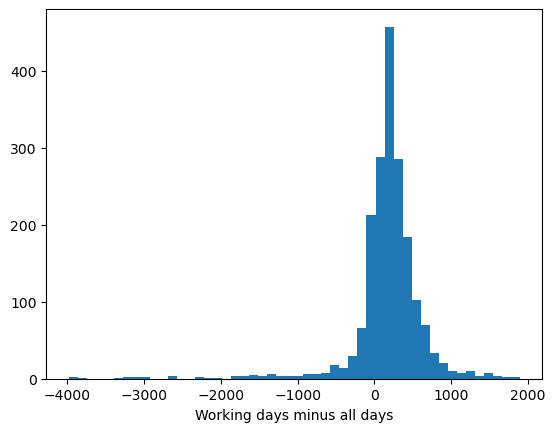

In [33]:
# Some roads are more busy during the weekends (negative values)
plt.hist((df.AAWT - df.AADT), bins = 50)
plt.xlabel('Working days minus all days')
plt.show()

In [40]:
df = df.join(
    gdf.set_index('iu_ac')[[
    'libelle', 'raw_oneway', 'raw_direction', 'osm_name', 'osm_type', 'osm_oneway', 'osm_lanes', 'osmid', 'geometry'
]].rename(columns = {'libelle':'raw_name'}),
    on = 'iu_ac',
    how = 'inner'
)

df

,AADT,AAWT,raw_name,raw_oneway,raw_direction,osm_name,osm_type,osm_oneway,osm_lanes,osmid,geometry
iu_ac,,,,,,,,,,,
5,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Pt_Neuf_Droite --> Megisserie-Bertin_Poiree,Quai de la Mégisserie,primary,True,4.0,53578234.0,"LINESTRING (2.34255 48.85846, 2.34434 48.85796)"
6,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Megisserie-Bertin_Poiree --> Megisserie-Edouar...,Quai de la Mégisserie,primary,True,4.0,53578234.0,"LINESTRING (2.34434 48.85796, 2.34578 48.85753)"
7,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Megisserie-Edouard_Colonne --> Chatelet,Quai de la Mégisserie,primary,True,5.0,68881721.0,"LINESTRING (2.34578 48.85753, 2.34712 48.85718)"
8,28034.970930,27916.733607,Quai_de_Gesvres,True,Chatelet --> Gesvres-Pt_Notre_Dame,Quai de Gesvres,primary,True,5.0,4039626.0,"LINESTRING (2.34712 48.85718, 2.34891 48.8567)"
9,32950.549724,32464.184109,Quai_de_Gesvres,True,Gesvres-Pt_Notre_Dame --> Gesvres-Tacherie,Quai de Gesvres,primary,True,4.0,284302748.0,"LINESTRING (2.34891 48.8567, 2.34947 48.85648)"
...,...,...,...,...,...,...,...,...,...,...,...
7203,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Pyrenees --> Menilmontant-Pixerec...,Rue de Ménilmontant,tertiary,NaN,2.0,24044438.0,"LINESTRING (2.39455 48.86999, 2.39578 48.87007)"
7204,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Pixerecourt-Chine --> Menilmontan...,Rue de Ménilmontant,tertiary,NaN,NaN,336799989.0,"LINESTRING (2.39578 48.87007, 2.39749 48.87023)"
7205,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Jakubowicz --> Menilmontant-St_Fa...,Rue de Ménilmontant,tertiary,NaN,NaN,336799989.0,"LINESTRING (2.39749 48.87023, 2.39782 48.87034..."


# Final save

In [41]:
gpd.GeoDataFrame(
    df,
    geometry = 'geometry',
    crs = 'epsg:4326'
    ).to_file(
    'treated/Paris_AADT_AAWT_2023.geojson', 
    index = False
)